In [131]:
%load_ext autoreload

%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
import problem
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import yaml

#from problem import *

In [133]:
with open('config_basic.yml', 'r') as file:
        c = yaml.safe_load(file)

# Create spatial discretisation 
lat_first = c['spatial_discretisation']['lat_first']
lat_final = c['spatial_discretisation']['lat_final']
lat_n     = c['spatial_discretisation']['lat_n']
lng_first = c['spatial_discretisation']['lng_first']
lng_final = c['spatial_discretisation']['lng_final']
lng_n     = c['spatial_discretisation']['lng_n']

lat,lng = jnp.mgrid[lat_first:lat_final:lat_n*1j,
                    lng_first:lng_final:lng_n*1j]

# test divfree projection with boundary condidtions

In [134]:
from problem import *

def project_divergencefree2(v, q_guess=None, state=None, neighbours=None):

    laplacian_f = laplacian if state is None else LaplacianBoundaryAware(state, neighbours).laplacian
    #if not state is None: v *= state


    q, _ = jsp.sparse.linalg.cg(
            laplacian_f,
            -divergence(v), 
            x0=q_guess,
            maxiter= MAXITER)
    #q_total = q
    v_f = (v + gradient(q)) * (1 if state is None else state)
    # Repeats as conjugate gradient descent does not necessarily converge to correct solution after 1 run
    for i in range(1):
        # q is the exact "pressure" needed to maintain densities
        q, _ = jsp.sparse.linalg.cg(
            laplacian_f,
            -divergence(v_f), 
            maxiter= MAXITER)
        #q_total += q
        v_f += gradient(q)
    return v_f

    #return v + gradient(q)


In [135]:
def neighbours(state):
    s_i_next = jnp.roll(state, shift=1, axis=-2)
    s_i_prev = jnp.roll(state, shift=-1,axis=-2)
    s_j_next = jnp.roll(state, shift=1 ,axis=-1)
    s_j_prev = jnp.roll(state, shift=-1,axis=-1)

    return s_i_next + s_i_prev + s_j_next + s_j_prev

In [136]:
T = 0 * lat
S = 0 * lat

# Initialise v as 0
v = jnp.zeros((2, lat.shape[0], lat.shape[1]))
# Add a spot of vertical movement
v = v.at[1].set( -1 * ((jnp.square(lat+0.5) + jnp.square(lng+0.5))<1) )
# Force v to be divergence free

state = 1 - 1 * ((jnp.square(lat+0.5) + jnp.square(lng+2))<0.7)
T*=state; S*=state; v*=state

fluid_neighbours = neighbours(state)

v = project_divergencefree2(v, state=state, neighbours = fluid_neighbours)

[0 1 2 3 4]


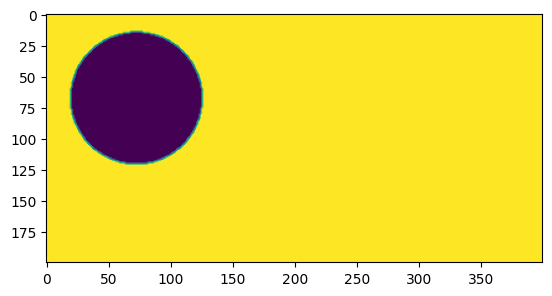

In [137]:
plt.imshow(neighbours(state))

print(jnp.unique(neighbours(state)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-528524770.0 528632670.0
-528796380.0 526354900.0
0 1


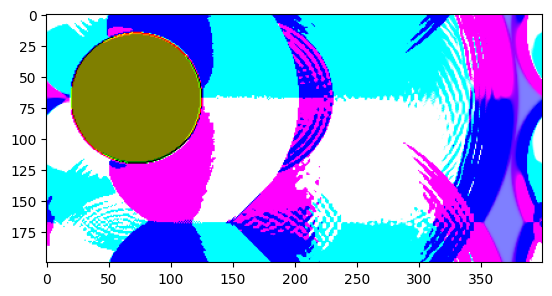

In [138]:
print(jnp.amin(v[0]), jnp.amax(v[0]))
print(jnp.amin(v[1]), jnp.amax(v[1]))
print(jnp.amin(state), jnp.amax(state))
plt.imshow(jnp.stack((v[0]/3 + 0.5, v[1]/3 + 0.5, state), axis=2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


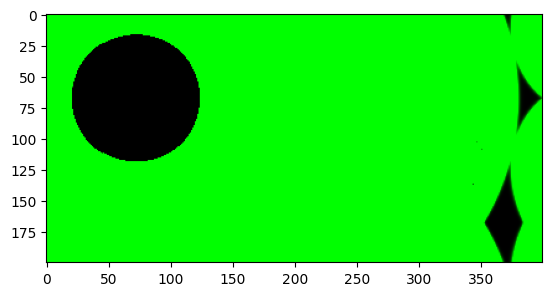

In [139]:
v_abs = jnp.sqrt( jnp.square(v[0]) + jnp.square(v[1]))

plt.imshow(jnp.stack(((v[0]/3 + 0.5)*0, 
                      (v[1]/3 + 0.5)*0 + v_abs, 
                      state * 0), axis=2))

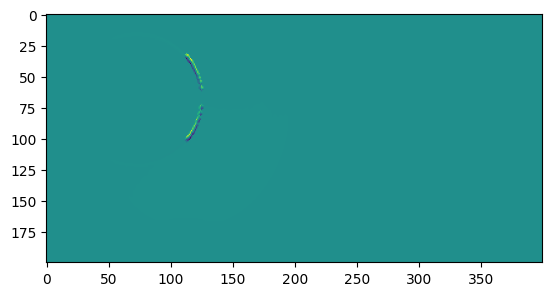

In [140]:
# BLUR V
v += (jnp.roll(v, 1,axis=-1)
     +jnp.roll(v,-1,axis=-1)
     +jnp.roll(v, 1,axis=-2)
     +jnp.roll(v,-1,axis=-2))
v/=5
plt.imshow(v[0])

In [141]:
def gradient(y):
    return jnp.array( (ptheta(y), plambda(y)))

-31820410000.0 18540999000.0


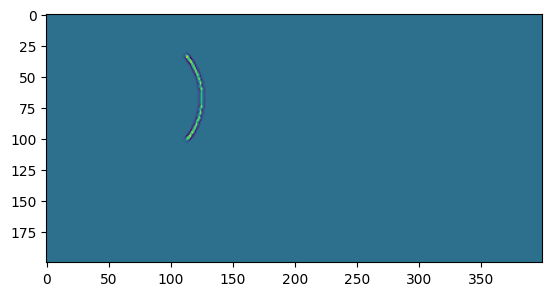

In [142]:
rhs = -divergence(v)
plt.imshow(-rhs)

print(jnp.amin(rhs), jnp.amax(rhs))

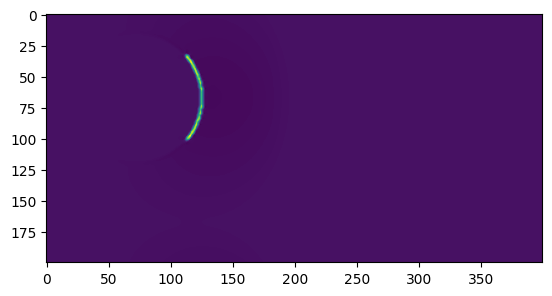

In [143]:
import jax.scipy as jsp
q, _ = jsp.sparse.linalg.cg(laplacian, rhs , maxiter= 10000)
plt.imshow( q)

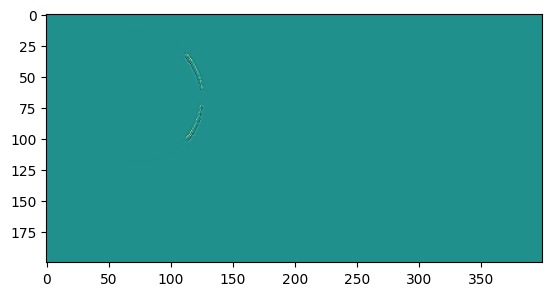

In [144]:
v_f = v +gradient(q)
plt.imshow(v_f[0])
#plt.imshow(v_f[1])

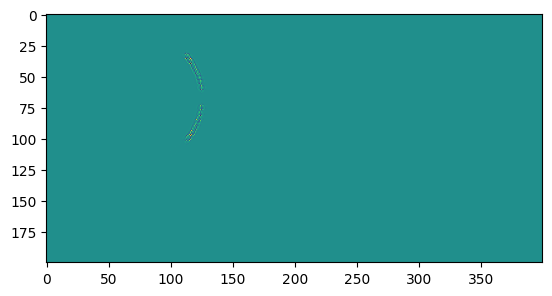

In [145]:

q, _ = jsp.sparse.linalg.cg(laplacian, -divergence( v_f ), maxiter= 100)
v_f = v_f + gradient(q)
plt.imshow(v_f[0])

-7171611600.0 9889473000.0


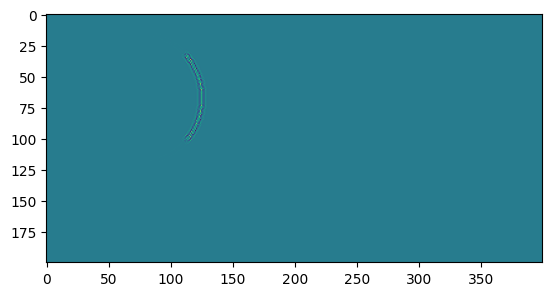

In [146]:
div = divergence(v_f)
plt.imshow(div)
print(jnp.amin(div), jnp.amax(div))

-99424.0 96640.0


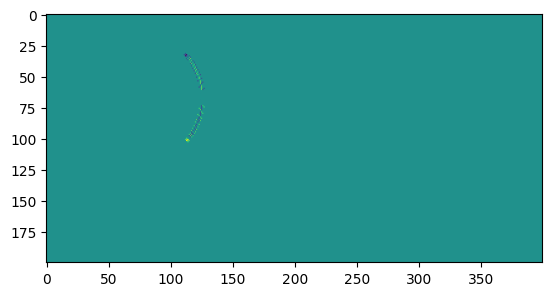

In [147]:
def curl(v):
    return ptheta(v[1]) - plambda(v[0])

c = curl(v_f)
plt.imshow(c)
print(jnp.amin(c), jnp.amax(c))

# bathymetry

In [148]:
import numpy as np

In [149]:
# Assuming `data` is your N-dimensional numpy array
data = np.random.rand(10, 20, 30)  # Example: 3D array
print('data created')

def plot_slice(x=0):
    plt.imshow(data[:, :, x], interpolation='nearest')
    plt.show()

interact(plot_slice, x=IntSlider(min=0, max=data.shape[2]-1, step=1, value=0))

data created


NameError: name 'interact' is not defined

opening path  /mnt/c/Users/spenc/OneDrive/Documents/GitHub/THCsim/resources/map/gebco_08_rev_bath_3600x1800_color.jpg
/mnt/c/Users/spenc/OneDrive/Documents/GitHub/THCsim/resources/map/gebco_08_rev_bath_3600x1800_color.jpg
(1800, 3600, 3)


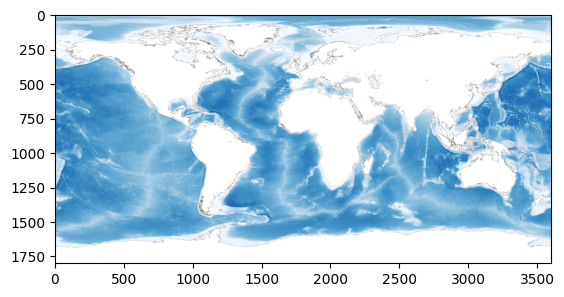

In [ ]:
import cv2
import numpy as np
import os

def get_map_path(config):

    if config["map"]["mask_image_path_relative"]:
        print('opening path ', os.path.join( os.getcwd(), config["map"]["mask_image_path"] ))
        print(os.path.join( os.getcwd(), config["map"]["mask_image_path"] ))
        return os.path.join( os.getcwd(), config["map"]["mask_image_path"] )
    else:
        return config["map"]["mask_image_path"]


def load_np(config):

    image_np = cv2.imread(get_map_path(config)) 

    return image_np[:,:,::-1]



import matplotlib.pyplot as plt

config = {"map": {"mask_image_path_relative": True, 
                    "mask_image_path": "resources/map/gebco_08_rev_bath_3600x1800_color.jpg"}}

im = load_np(config).astype(int)
print(im.shape)

im[:,:,:] += (np.isclose(im[:,:,0],im[:,:,2], atol=4))[:,:,np.newaxis]*255

im[im>255]=255

plt.imshow(im)
#plt.show()